# Imports Necessary Libraries

In [61]:
!pip install optuna

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
#for hyper parameter tuning
import optuna
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [63]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#  Data Analysis

**1.1 Load Data**

In [94]:
wids_train = pd.read_csv("gdrive/MyDrive/Dataset/wids/training.csv")
wids_test = pd.read_csv("gdrive/MyDrive/Dataset/wids/test.csv")
sample_submission = pd.read_csv("gdrive/MyDrive/Dataset/wids/sample_submission.csv")


In [65]:
wids_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

In [66]:
wids_train.head(5)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [67]:
wids_train.describe().T.style.background_gradient(cmap='twilight', axis=0)

,count,mean,std,min,25%,50%,75%,max
patient_id,12906.000000,547381.196033,260404.959974,100063.000000,321517.000000,543522.000000,772671.750000,999896.000000
patient_zip3,12906.000000,573.754300,275.447534,101.000000,331.000000,554.000000,846.000000,999.000000
patient_age,12906.000000,59.183326,13.335216,18.000000,50.000000,59.000000,67.000000,91.000000
bmi,3941.000000,28.984539,5.696906,14.000000,24.660000,28.190000,32.920000,85.000000
population,12905.000000,20744.441237,13886.903756,635.545455,9463.896552,19154.190480,30021.278690,71374.131580
density,12905.000000,1581.950419,2966.305306,0.916667,171.857143,700.337500,1666.515385,21172.000000
age_median,12905.000000,40.502259,4.036963,20.600000,37.129825,40.639344,42.934783,54.570000
age_under_10,12905.000000,11.122784,1.512376,0.000000,10.160000,11.039216,12.190000,17.675000
age_10_to_19,12905.000000,12.945265,1.923974,6.314286,11.741176,12.923944,14.019767,35.300000
age_20s,12905.000000,13.290376,3.354103,5.925000,11.013415,12.538095,14.971053,62.100000


**Check null values**

In [95]:
print(wids_train.isnull().sum())


patient_id           0
patient_race      6385
payer_type        1803
patient_state       51
patient_zip3         0
                  ... 
veteran              1
Ozone               29
PM25                29
N02                 29
DiagPeriodL90D       0
Length: 83, dtype: int64


In [96]:
print(wids_test.isnull().sum())

patient_id             0
patient_race        2901
payer_type           760
patient_state         21
patient_zip3           0
                    ... 
health_uninsured       0
veteran                0
Ozone                 14
PM25                  14
N02                   14
Length: 82, dtype: int64


**1.5 Check feature types**

In [97]:
def get_feature_types(data):
    return {col: "numerical" if pd.api.types.is_numeric_dtype(data[col]) else "categorical" for col in data}
#to apply one hot encoding
for col, feat_type in get_feature_types(wids_train).items():
  if feat_type=='categorical':
    print(col+":"+feat_type)


patient_race:categorical
payer_type:categorical
patient_state:categorical
patient_gender:categorical
breast_cancer_diagnosis_code:categorical
breast_cancer_diagnosis_desc:categorical
metastatic_cancer_diagnosis_code:categorical
metastatic_first_novel_treatment:categorical
metastatic_first_novel_treatment_type:categorical
Region:categorical
Division:categorical


# 2 Data Viz


**2.1  correlation between air quality and cancer diagnosis **


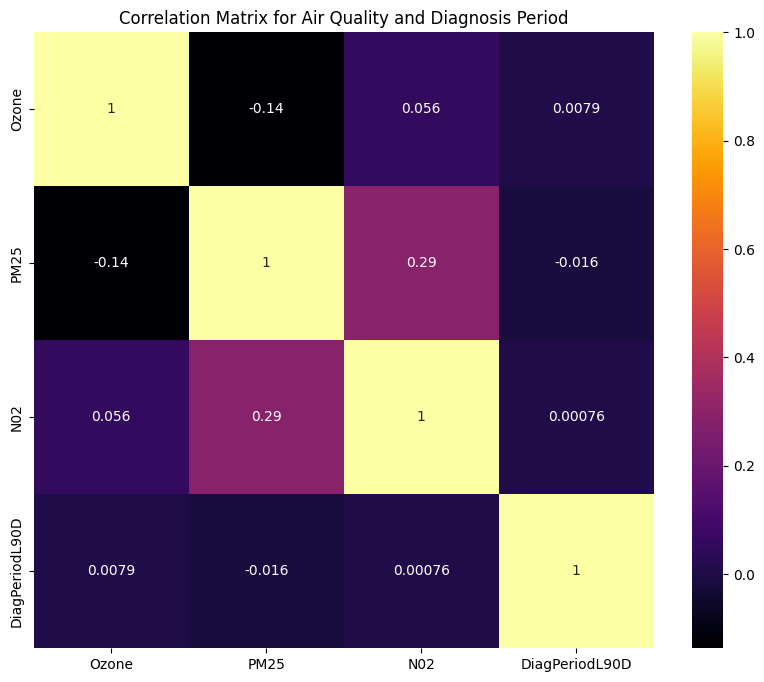

In [71]:
correlation_matrix = wids_train[['Ozone', 'PM25', 'N02', 'DiagPeriodL90D']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno')
plt.title('Correlation Matrix for Air Quality and Diagnosis Period')
plt.show()


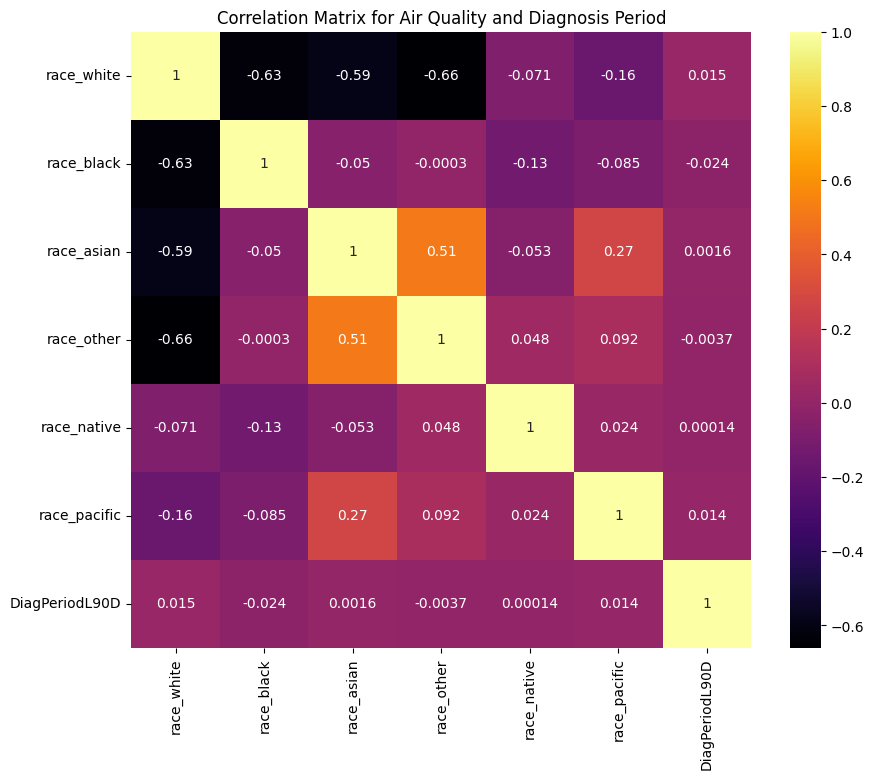

In [72]:
correlation_matrix = wids_train[['race_white', 'race_black', 'race_asian','race_other', 'race_native','race_pacific','DiagPeriodL90D']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno')
plt.title('Correlation Matrix for Air Quality and Diagnosis Period')
plt.show()


**2.2 Count the occurrences of each payer type**

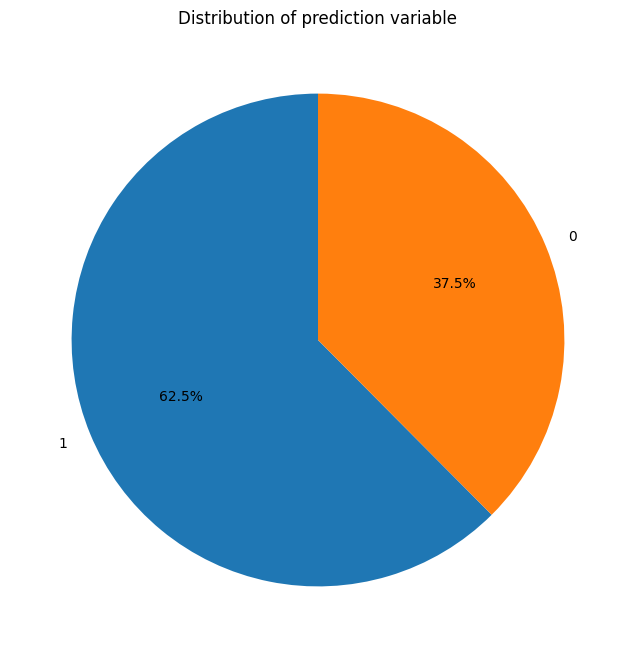

In [73]:

payer_counts = wids_train['DiagPeriodL90D'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(payer_counts, labels=payer_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of prediction variable')
plt.show()


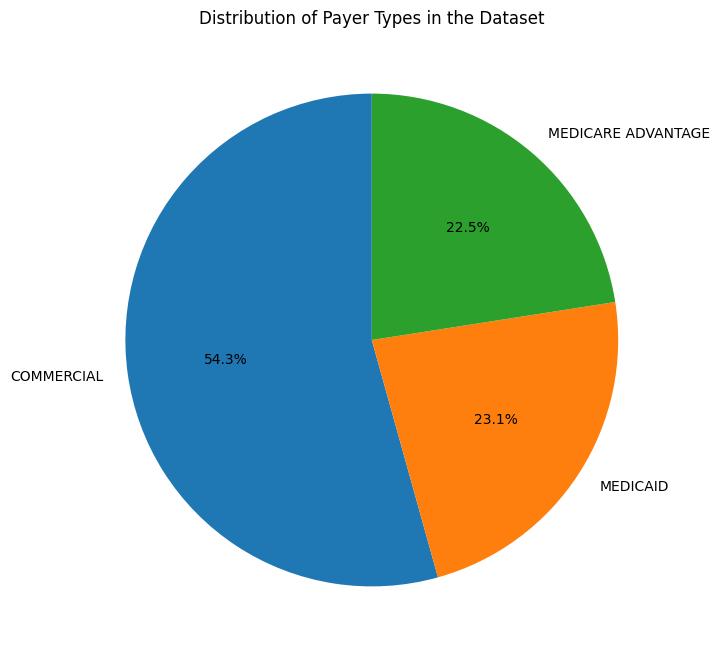

In [74]:

payer_counts = wids_train['payer_type'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(payer_counts, labels=payer_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Payer Types in the Dataset')
plt.show()


**2.3 relationship between socioeconomic factors (income, education) and the diagnosis period?**


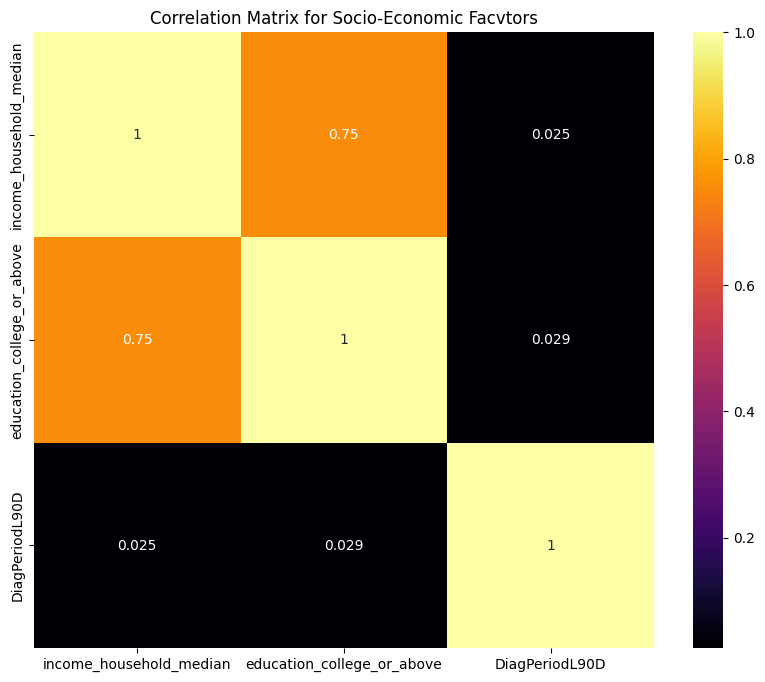

In [75]:


correlation_matrix = wids_train[['income_household_median', 'education_college_or_above','DiagPeriodL90D']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno')
plt.title('Correlation Matrix for Socio-Economic Facvtors')
plt.show()


#  Feature Engineering

** Drop unnecessary columns**

In [76]:
drop_columns = ['patient_id']
wids_train = wids_train.drop(columns=drop_columns)
wids_test = wids_test.drop(columns=drop_columns)

**Drop Target variable for training**



In [77]:
X = wids_train.drop(columns=['DiagPeriodL90D'])
y = wids_train['DiagPeriodL90D']

** Split the data into training and test**

In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

**Preprocessing for numerical and categorical data**

In [79]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns
#filling missing values with mean of numerical values
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
#filling missing values with most frequent category value
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

**Bundle data**

In [80]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



#Model Building and Evaluation

**4.1 Define XGBoost model with Optuna hyperparameter optimization**

In [81]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'random_state': 42
    }

    xgb_model = XGBClassifier(**params)

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb_model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)

    return auc

In [117]:
transformed_cols = preprocessor.named_transformers_['num']['scaler'].get_feature_names_out(numerical_cols).tolist() + \
                       preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols).tolist()


In [119]:
len(transformed_cols)

283

**4.2 Create and run the Optuna study**

In [82]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

**4.3 Get the best parameters**

In [83]:
best_params = study.best_params

**4.3 Train XGBoost model with best hyperparametersl**

In [84]:
xgb_model = XGBClassifier(**best_params, random_state=42)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', xgb_model)])
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['patient_zip3', 'patient_age', 'bmi', 'population', 'density',
       'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s',
       'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male',
       'female', 'marrie...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.05183291839488269, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=95,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

**4.4 Evaluate XGBoost model**

In [149]:
y_pred = clf.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_pred)
print(f'XGBoost: AUC = {auc:.4f}')

XGBoost: AUC = 0.8044


In [147]:
len(y_pred)

2582

**4.5 Make predictions on test set**

In [86]:
final_predictions = clf.predict_proba(wids_test)[:, 1]

In [88]:
feature_importances = xgb_model.feature_importances_

In [90]:
len(feature_importances)

283

**K-cross Fold validation**

In [151]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

# number of folds
n_splits = 10

#  StratifiedKFold
stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

#  cross-validation results
cv_results = []

# stratified k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    clf.fit(X_train, y_train)

    # predictions on the validation set
    y_val_pred_prob = clf.predict(X_val)
    y_pred = clf.predict(X_val)

    f1=  f1_score(y_val, y_pred, average='weighted')

    # Evaluating the model

    roc_auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
    print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
    print('-'*70)

    # results
    cv_results.append(roc_auc)

# average cross-validation result
average_cv_result = sum(cv_results) / n_splits
print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')


Fold 1, AUC Score on Validation Set: 0.7533268527282495
Fold 1, F1 Score on Validation Set: 0.7898929781129436
----------------------------------------------------------------------
Fold 2, AUC Score on Validation Set: 0.7457176843774782
Fold 2, F1 Score on Validation Set: 0.7847399757464733
----------------------------------------------------------------------
Fold 3, AUC Score on Validation Set: 0.7650955462894272
Fold 3, F1 Score on Validation Set: 0.8019173868355359
----------------------------------------------------------------------
Fold 4, AUC Score on Validation Set: 0.7611816019032515
Fold 4, F1 Score on Validation Set: 0.7987599896356187
----------------------------------------------------------------------
Fold 5, AUC Score on Validation Set: 0.7498413957176844
Fold 5, F1 Score on Validation Set: 0.7885074204640089
----------------------------------------------------------------------
Fold 6, AUC Score on Validation Set: 0.7659167071704484
Fold 6, F1 Score on Validation Set

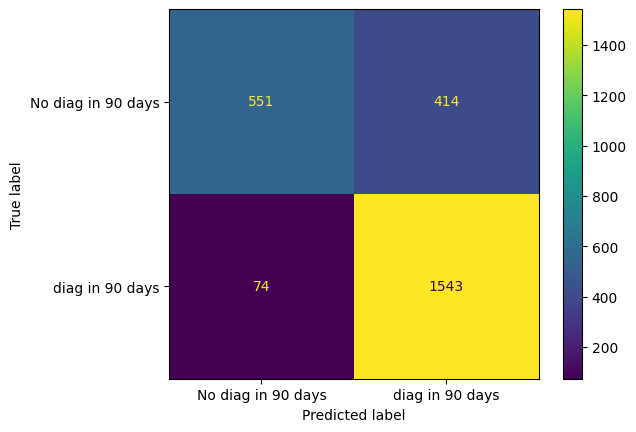

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import  confusion_matrix

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X = X_train,
                y = y_train)

predictions_xgb = clf.predict(X_val)

cm_xgb = confusion_matrix(y_val, predictions_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['No diag in 90 days', 'diag in 90 days'])
disp.plot()
plt.show()

**LGBM**

In [154]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
# #LGBM Best parameters:  {'max_depth': 7, 'min_child_samples': 19, 'learning_rate': 0.013570653703644641, 'n_estimators': 425, 'subsample': 0.3220447078654888, 'colsample_bytree': 0.6332250329962271, 'reg_alpha': 0.020790829521639388, 'reg_lambda': 0.8238668916252945}
lgbm_params_optuna =  {'max_depth': 7,
                       'min_child_samples': 19,
                       'learning_rate': 0.013570653703644641,
                       'n_estimators': 425,
                       'subsample': 0.3220447078654888,
                       'colsample_bytree': 0.6332250329962271,
                       'reg_alpha': 0.020790829521639388,
                       'reg_lambda': 0.8238668916252945}

# lgbm model
lgbm_model = LGBMClassifier(**lgbm_params_optuna)

lgbm = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', lgbm_model)])
lgbm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['patient_zip3', 'patient_age', 'bmi', 'population', 'density',
       'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s',
       'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male',
       'female', 'marrie...
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division'],
      dtype='object'))])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.6332250329962271,
                                learning_rate=0.013570653703644641, max_depth=7,
                                min_child_samples=19, n_estimators=425,
                                reg_alpha=0.020790829521639388,
                                reg_lambda=0.8238668916252945,
                                subsample=0.3220447078654888))])

In [156]:
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_pred)
print(f'XGBoost: AUC = {auc:.4f}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6443, number of negative: 3881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17692
[LightGBM] [Info] Number of data points in the train set: 10324, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624080 -> initscore=0.506901
[LightGBM] [Info] Start training from score 0.506901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [157]:
final_predictions = lgbm.predict_proba(wids_test)[:, 1]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


#Feature Importance

In [124]:

feature_importances = clf.named_steps['classifier'].feature_importances_

# Retrieve transformed column names after the pipeline
transformed_cols = preprocessor.named_transformers_['num']['scaler'].get_feature_names_out(numerical_cols).tolist() + \
                    preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols).tolist()
booster_feature_names = clf.named_steps['classifier'].get_booster().feature_names
if booster_feature_names is not None:
        all_feature_names = transformed_cols + booster_feature_names
else:
        all_feature_names = transformed_cols

    # Create a dictionary mapping feature names to their corresponding importance scores
feature_importance_dict = dict(zip(all_feature_names, feature_importances))






In [125]:
feature_importance_dict

{'patient_zip3': 0.0012307372,
 'patient_age': 0.0012885056,
 'bmi': 0.0011838814,
 'population': 0.00083201885,
 'density': 0.001170491,
 'age_median': 0.0011653012,
 'age_under_10': 0.0012918017,
 'age_10_to_19': 0.001287672,
 'age_20s': 0.0010776846,
 'age_30s': 0.0012630171,
 'age_40s': 0.001525673,
 'age_50s': 0.0013002278,
 'age_60s': 0.0014144663,
 'age_70s': 0.0011786856,
 'age_over_80': 0.0012236058,
 'male': 0.0014032803,
 'female': 0.0020381669,
 'married': 0.0011893812,
 'divorced': 0.0012561032,
 'never_married': 0.0017491999,
 'widowed': 0.0013532946,
 'family_size': 0.0013997505,
 'family_dual_income': 0.0015627065,
 'income_household_median': 0.0012801768,
 'income_household_under_5': 0.0017256746,
 'income_household_5_to_10': 0.0014646106,
 'income_household_10_to_15': 0.0011513202,
 'income_household_15_to_20': 0.0013565515,
 'income_household_20_to_25': 0.0014376569,
 'income_household_25_to_35': 0.0018560501,
 'income_household_35_to_50': 0.0010842108,
 'income_hous

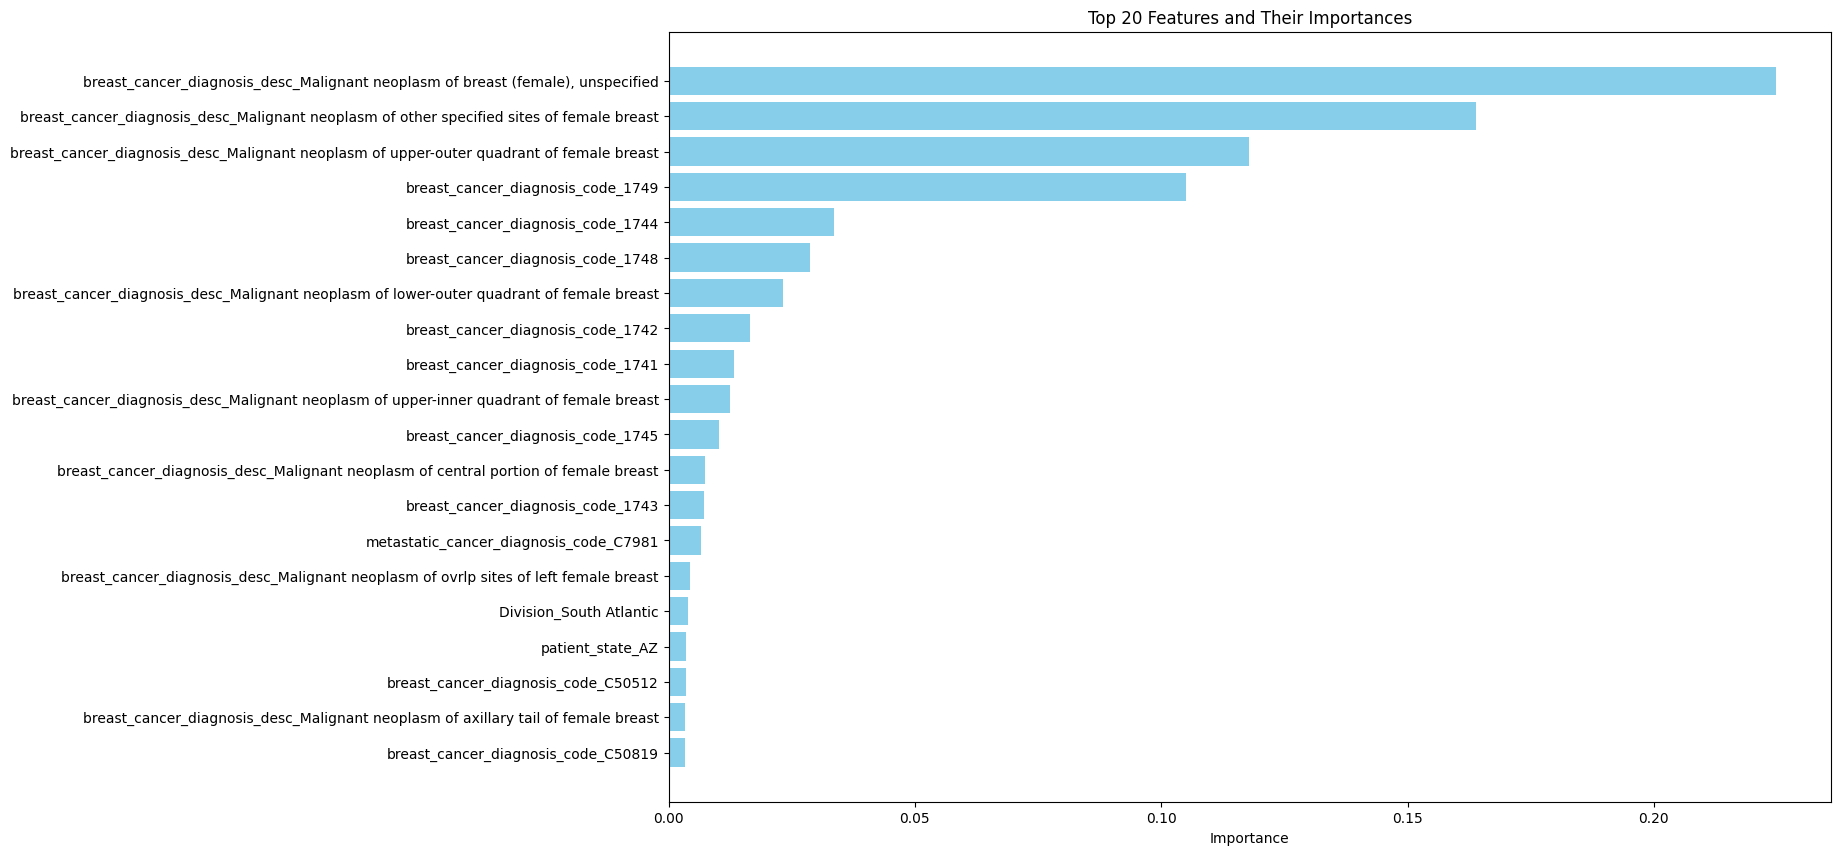

In [129]:
import matplotlib.pyplot as plt

# Assuming best_feature_importance_dict contains the feature importances

# Sort the dictionary by importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the top 20 features and importances in reverse order
top_features = [item[0] for item in sorted_feature_importance[:20]][::-1]
top_importances = [item[1] for item in sorted_feature_importance[:20]][::-1]

# Plot the top 20 features
plt.figure(figsize=(15, 10))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Features and Their Importances')
plt.show()


# Prepare submission file

In [ ]:
wids_test = pd.read_csv("gdrive/MyDrive/Dataset/wids/test.csv")

In [158]:
submission_df = pd.DataFrame({'patient_id': wids_test['patient_id'], 'DiagPeriodL90D': final_predictions})
submission_df.to_csv('submission_lgbm.csv', index=False)

#Different ALgorithms:

In [91]:
wids_train = pd.read_csv("gdrive/MyDrive/Dataset/wids/training.csv")
wids_test = pd.read_csv("gdrive/MyDrive/Dataset/wids/test.csv")
sample_submission = pd.read_csv("gdrive/MyDrive/Dataset/wids/sample_submission.csv")


In [112]:
def split_numerical_categorical(input_df):
    # Identify numerical and categorical columns
    numerical_cols = input_df.select_dtypes(include=['number']).columns
    categorical_cols = input_df.select_dtypes(include=['object']).columns

    # Create DataFrames with only numerical and categorical columns
    numerical_df = input_df[numerical_cols].copy()
    categorical_df = input_df[categorical_cols].copy()

    for col in numerical_cols:
      if input_df[col].isnull().any():
            input_df[col] = input_df[col].fillna(input_df[col].mean())

    # Replace missing values in categorical columns with the most frequent value
    for col in categorical_cols:
        if input_df[col].isnull().any():
            input_df[col] = input_df[col].fillna(input_df[col].mode().iloc[0])
    # Apply standard scaling to numerical columns
    scaler = StandardScaler()
    numerical_df[numerical_cols] = scaler.fit_transform(numerical_df[numerical_cols])
    # Apply one-hot encoding to categorical columns
    categorical_df = pd.get_dummies(categorical_df, columns=categorical_cols, drop_first=True)

    return numerical_df, categorical_df

# Example usage:
# Assuming 'your_dataframe' is the DataFrame you want to split
numerical_data, categorical_data = split_numerical_categorical(wids_train)


In [114]:
n_df=numerical_data
c_df=categorical_data

In [115]:
n_df.head()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,-0.275225,1.271601,1.861060,1.128675e-15,0.770088,-0.132292,-2.442471,3.234566,1.350223,1.289240,...,-0.125688,1.749676,1.163125,-0.032281,0.624463,-1.152663,3.491878,0.775933,0.429689,0.775397
1,-0.760438,1.286123,0.211229,-1.571121e-01,1.323467,0.240718,-0.570339,0.499917,0.212743,0.280254,...,-1.186162,-0.631594,0.740800,0.516898,-0.370460,-0.958686,0.697194,0.668073,0.687867,0.775397
2,-1.569728,0.676183,-1.213625,2.892748e+00,0.090181,-0.322215,-0.643006,1.260068,0.789089,-0.226221,...,-0.564117,-0.716964,-0.231236,0.672076,1.544407,0.116859,0.080401,0.110601,-0.215850,0.775397
3,0.270596,1.278862,-1.063640,1.128675e-15,0.867855,0.105955,0.586915,-0.695222,-0.420802,-0.224304,...,-1.216600,-0.903738,0.166661,-0.081927,-0.992236,-0.731429,0.632208,-0.162292,-0.035105,-1.289662
4,1.037274,0.952108,-0.313717,1.128675e-15,-0.709946,-0.493940,0.736059,-0.197575,0.535774,-1.132544,...,0.525841,-0.418071,-0.522928,-0.355692,0.835733,1.937294,0.431379,-2.221162,-0.750002,-1.289662


In [116]:
c_df.head()

,patient_race_Black,patient_race_Hispanic,patient_race_Other,patient_race_White,payer_type_MEDICAID,payer_type_MEDICARE ADVANTAGE,patient_state_AL,patient_state_AR,patient_state_AZ,patient_state_CA,...,Region_South,Region_West,Division_East South Central,Division_Middle Atlantic,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central
0,0,0,0,1,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [111]:
c_df.head()

,patient_race,payer_type,patient_state,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division
0,White,MEDICAID,CA,F,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,PEMBROLIZUMAB,Antineoplastics,West,Pacific
1,White,COMMERCIAL,CA,F,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,PEMBROLIZUMAB,Antineoplastics,West,Pacific
2,White,COMMERCIAL,TX,F,C50112,Malignant neoplasm of central portion of left ...,C773,PEMBROLIZUMAB,Antineoplastics,South,West South Central
3,White,COMMERCIAL,CA,F,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,PEMBROLIZUMAB,Antineoplastics,West,Pacific
4,White,COMMERCIAL,ID,F,1749,"Malignant neoplasm of breast (female), unspeci...",C773,PEMBROLIZUMAB,Antineoplastics,West,Mountain


#Lime-Shap Analysis

In [131]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=3707a99faf987952c5f00dcfd9d3c3c301798dc37be76658e39fc74be720b95e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [133]:
from lime import lime_tabular

# Assuming 'X_valid' is your validation set, 'clf' is your trained model
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,  # Use your training set here
    feature_names=X_train.columns,
    class_names=['class_0', 'class_1'],
    categorical_features='auto',  # Auto-detect categorical features
    mode='classification'
)

# Choose a specific sample for explanation
sample_index = 0  # Change this index as needed
sample = X_valid.iloc[[sample_index]].values[0]
exp = explainer.explain_instance(sample, clf.predict_proba, num_features=len(X_valid.columns))

# Display the explanation
exp.show_in_notebook(show_all=False)


TypeError: '<' not supported between instances of 'str' and 'float'